# ArtEmis exploration

In [1]:
import os.path as osp
import ast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.stats import entropy
import sklearn

from emotionpredictor.visual import save_fig
import emotionpredictor.visual as visual
from artemis.emotions import ARTEMIS_EMOTIONS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set_theme(context = "notebook", palette = "pastel" )

In [3]:
#paths
artemis_preprocess_path = "../../code/artemis/data_sets/artemis_preprocessed.csv"
image_emotion_histogram_path = "../../code/artemis/data_sets/image-emotion-histogram.csv"

In [4]:
dataset = pd.read_csv(artemis_preprocess_path)

In [5]:
index2painting = pd.read_csv("index2painting")
index2painting = index2painting.image_files

In [6]:
emotion2index = dict(zip(ARTEMIS_EMOTIONS, range(9)))
emotion2index

{'amusement': 0,
 'awe': 1,
 'contentment': 2,
 'excitement': 3,
 'anger': 4,
 'disgust': 5,
 'fear': 6,
 'sadness': 7,
 'something else': 8}

# Emotion distribution per art movement

In [7]:
dataset["year"] = dataset.painting.map(lambda y : y[-4:])
dataset.head(2)

art_style                                           painting  \
0  Post_Impressionism  vincent-van-gogh_portrait-of-madame-ginoux-l-a...   
1  Post_Impressionism  vincent-van-gogh_portrait-of-madame-ginoux-l-a...   

          emotion                                          utterance  \
0  something else  She seems very happy in the picture, and you w...   
1         sadness  This woman has really knotty hands which makes...   

   repetition  split                                             tokens  \
0          10  train  ['she', 'seems', 'very', 'happy', 'in', 'the',...   
1          10  train  ['this', 'woman', 'has', 'really', 'knotty', '...   

   tokens_len                                  utterance_spelled  \
0          18  she seems very happy in the picture and you wa...   
1          14  this woman has really knotty hands which makes...   

                                      tokens_encoded  emotion_label  year  
0  [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...              8  1890  
1  [1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30...              7  1890

In [8]:
print(f"Ratio of the dataset with a date :{dataset.year.str.isdigit().mean():.2f}")

Ratio of the dataset with a date :0.55


In [9]:
dated_dataset = dataset[dataset.year.str.isdigit()]
dated_dataset.year = dated_dataset.year.map(int)

/Users/robin/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [10]:
dated_dataset[dated_dataset.year<2020].groupby("art_style")["year"].mean().astype(int).sort_values()

art_style
Ukiyo_e                       1458
Early_Renaissance             1460
Northern_Renaissance          1504
High_Renaissance              1511
Mannerism_Late_Renaissance    1559
Baroque                       1648
Rococo                        1764
Romanticism                   1850
Realism                       1888
Impressionism                 1896
Pointillism                   1898
Symbolism                     1909
Art_Nouveau_Modern            1909
Analytical_Cubism             1910
Post_Impressionism            1911
Synthetic_Cubism              1915
New_Realism                   1923
Cubism                        1928
Fauvism                       1930
Expressionism                 1931
Naive_Art_Primitivism         1942
Action_painting               1955
Abstract_Expressionism        1970
Minimalism                    1972
Color_Field_Painting          1972
Pop_Art                       1976
Contemporary_Realism          1979
Name: year, dtype: int64

In [11]:
dated_dataset.year = dated_dataset.year.astype(int)

In [12]:
emotion_per_style = pd.DataFrame(dated_dataset.groupby("art_style").emotion.value_counts(normalize = True))

In [13]:
avg_emotion_per_style = dated_dataset.groupby("art_style").emotion.value_counts(normalize = True)
art_styles = list(avg_emotion_per_style.index.levels[0])
avg_emotion_per_style = pd.concat([avg_emotion_per_style[style] for style in art_styles], 1)
avg_emotion_per_style.columns = art_styles
avg_emotion_per_style

<ipython-input-13-835d175026ec>:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  avg_emotion_per_style = pd.concat([avg_emotion_per_style[style] for style in art_styles], 1)


Abstract_Expressionism  Action_painting  Analytical_Cubism  \
emotion                                                                      
something else                0.196448         0.207589           0.230612   
contentment                   0.149175         0.069196           0.095918   
excitement                    0.127611         0.165179           0.097959   
fear                          0.114841         0.129464           0.095918   
disgust                       0.111882         0.129464           0.116327   
amusement                     0.107400         0.109375           0.075510   
awe                           0.097759         0.049107           0.157143   
sadness                       0.053953         0.046875           0.116327   
anger                         0.040930         0.093750           0.014286   

                Art_Nouveau_Modern   Baroque  Color_Field_Painting  \
emotion                                                              
something else            0.121724  0.097454              0.261541   
contentment               0.250573  0.221247              0.220344   
excitement                0.098651  0.056287              0.112721   
fear                      0.096870  0.098625              0.050859   
disgust                   0.036729  0.045947              0.074879   
amusement                 0.143015  0.111989              0.121176   
awe                       0.159131  0.208858              0.061863   
sadness                   0.079905  0.147205              0.052872   
anger                     0.013402  0.012389              0.043747   

                Contemporary_Realism    Cubism  Early_Renaissance  \
emotion                                                             
something else              0.107468  0.162503           0.115908   
contentment                 0.262295  0.195190           0.152957   
excitement                  0.071949  0.120781           0.051326   
fear                        0.109290  0.068695           0.097213   
disgust                     0.046448  0.058863           0.053705   
amusement                   0.095628  0.188281           0.073080   
awe                         0.159381  0.120117           0.275663   
sadness                     0.139344  0.069360           0.163494   
anger                       0.008197  0.016210           0.016655   

                Expressionism  ...  Northern_Renaissance  Pointillism  \
emotion                        ...                                      
something else       0.118231  ...              0.093464     0.088523   
contentment          0.210334  ...              0.159477     0.378510   
excitement           0.072428  ...              0.059314     0.123321   
fear                 0.134657  ...              0.133660     0.044567   
disgust              0.085785  ...              0.065523     0.018315   
amusement            0.117735  ...              0.107680     0.076313   
awe                  0.107897  ...              0.218627     0.166667   
sadness              0.136462  ...              0.143301     0.096459   
anger                0.016471  ...              0.018954     0.007326   

                 Pop_Art  Post_Impressionism   Realism    Rococo  Romanticism  \
emotion                                                                         
something else  0.162049            0.102999  0.106779  0.091034     0.081751   
contentment     0.137571            0.387190  0.334314  0.296893     0.267691   
excitement      0.156926            0.082938  0.060305  0.068816     0.079355   
fear            0.058254            0.062142  0.088201  0.074518     0.126746   
disgust         0.071727            0.044674  0.032438  0.038537     0.029218   
amusement       0.239089            0.075696  0.066944  0.117578     0.071700   
awe             0.096395            0.140089  0.160853  0.223358     0.219073   
sadness         0.057685            0.093066  0.139072  0.076681     0.114416   
anger       

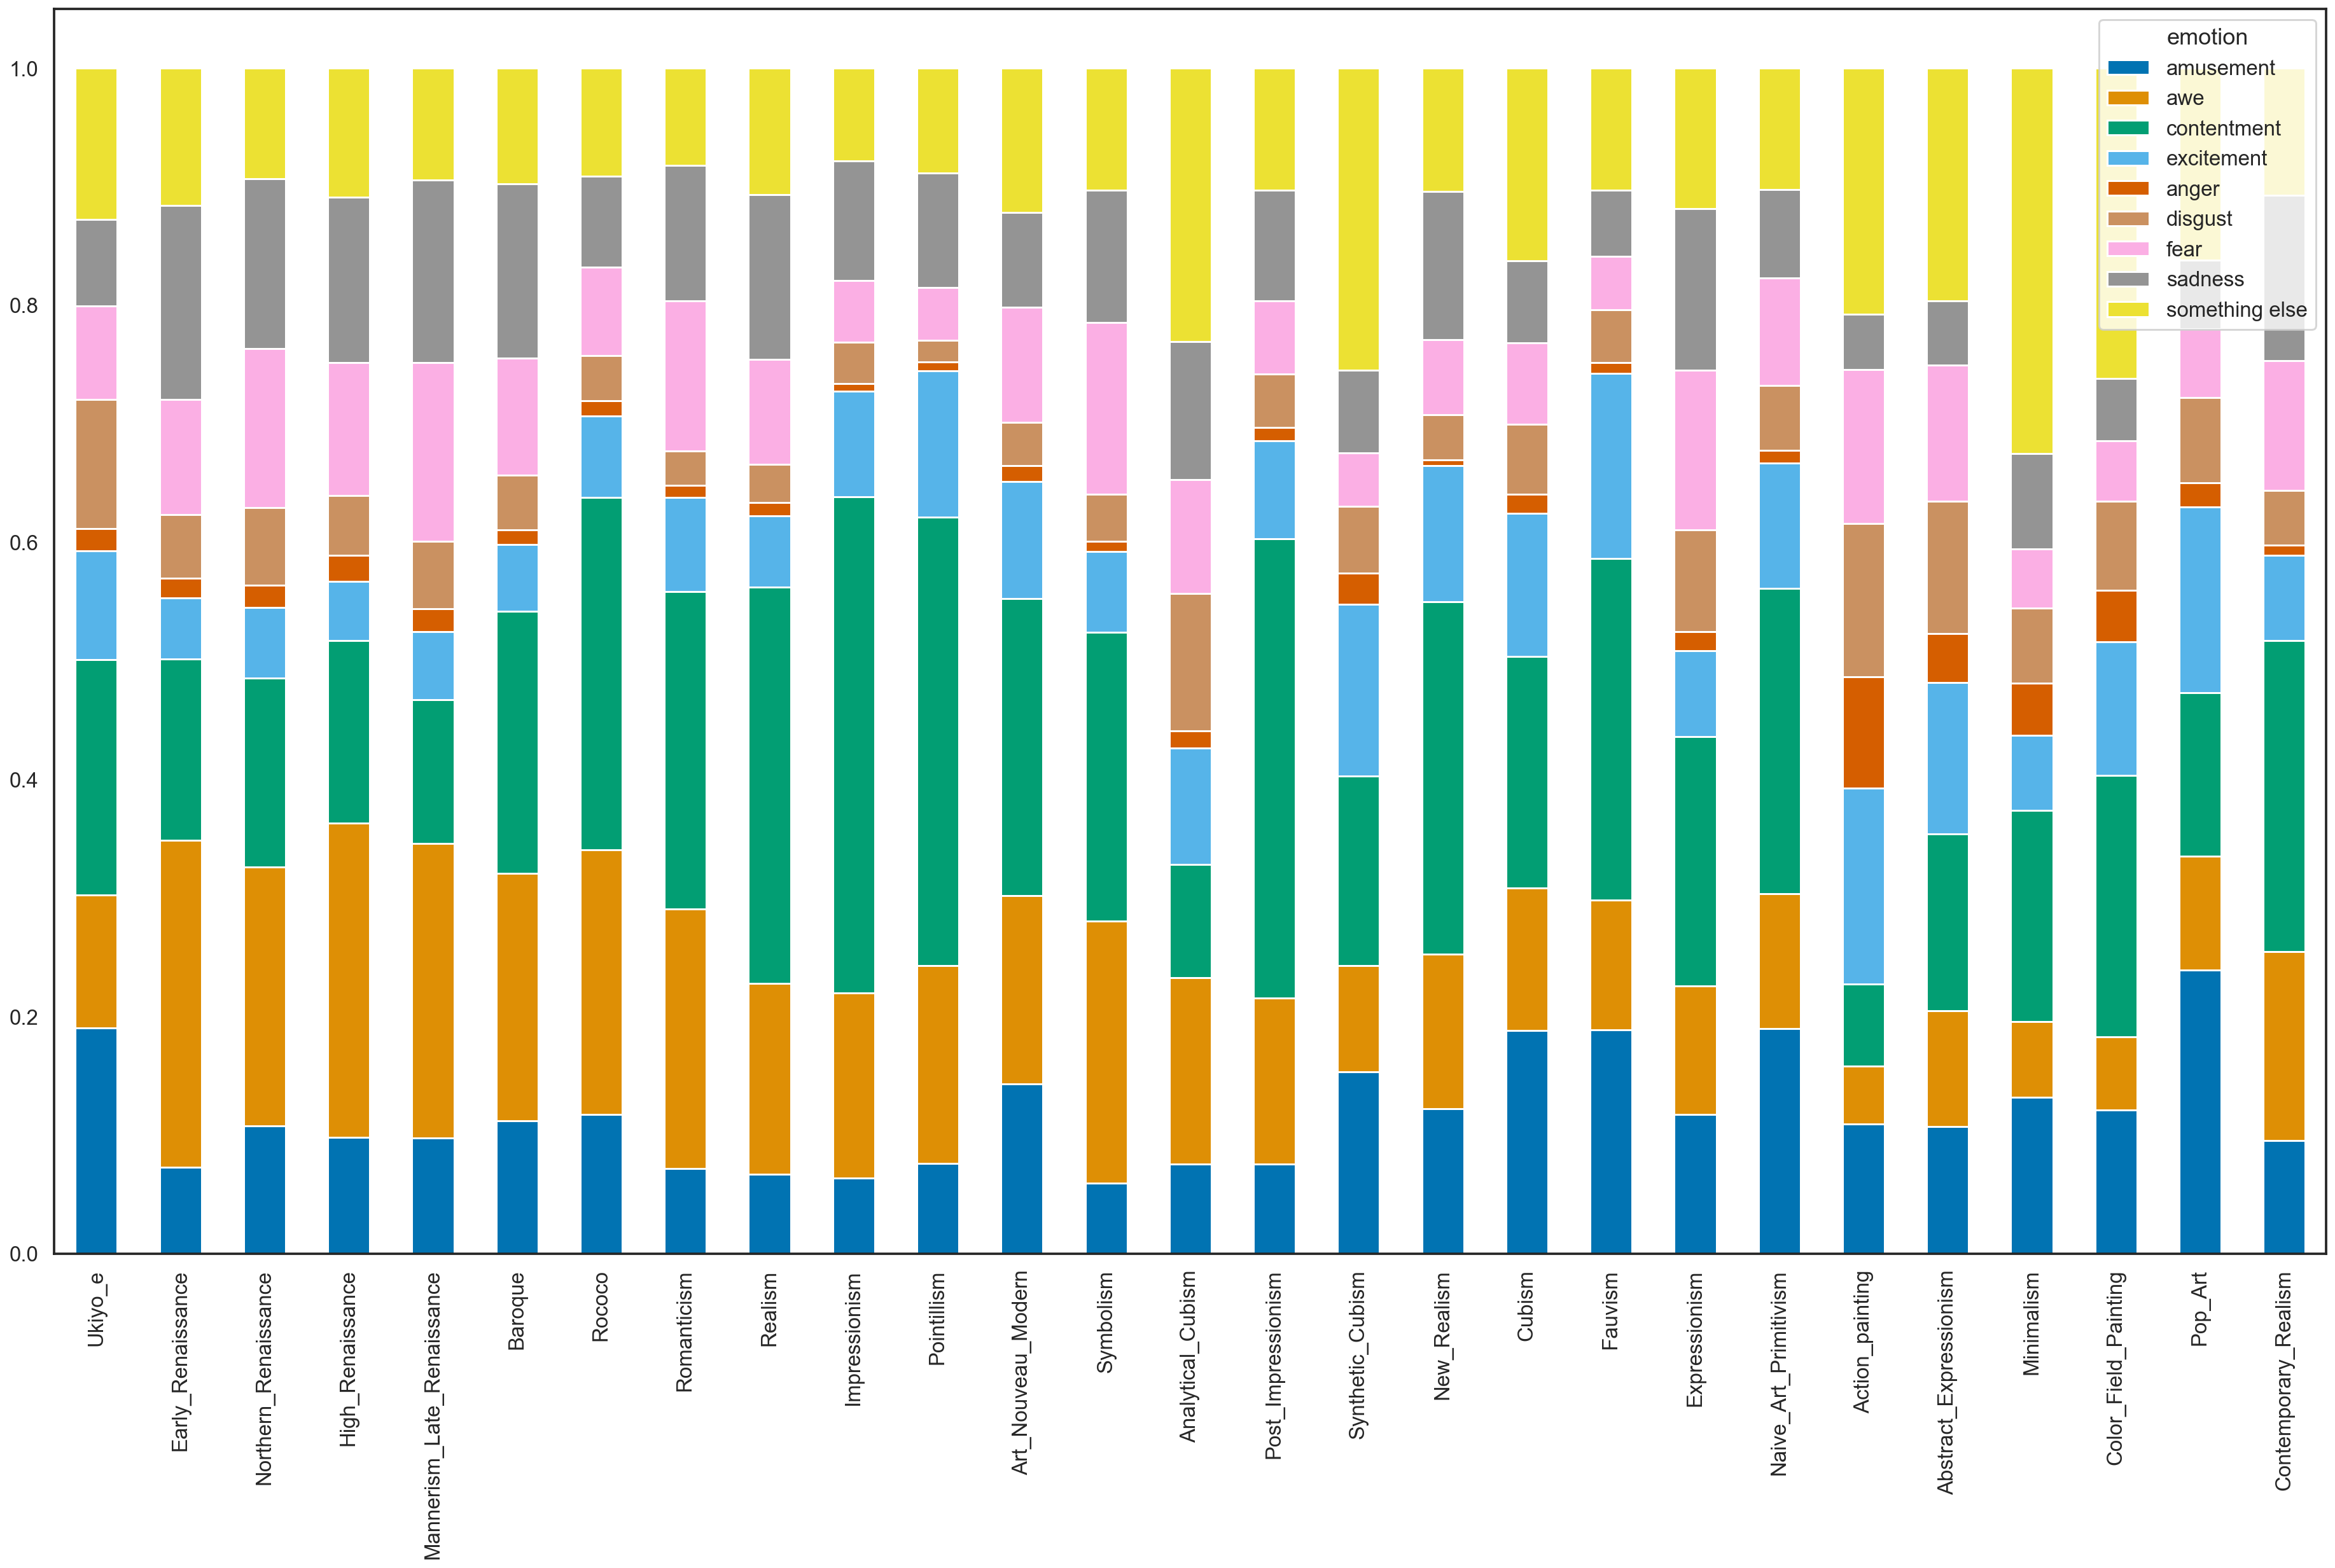

In [14]:
sns.set_theme(context = "talk", style = "white" )
date_movements = dated_dataset[dated_dataset.year<2020].groupby("art_style")["year"].mean()
avg_emotion_per_style[date_movements.sort_values().index].T[ARTEMIS_EMOTIONS].plot(kind = "bar",
                                                               stacked =True,
                                                               figsize = (32,18),
                                                           color = visual.emotion_colors());


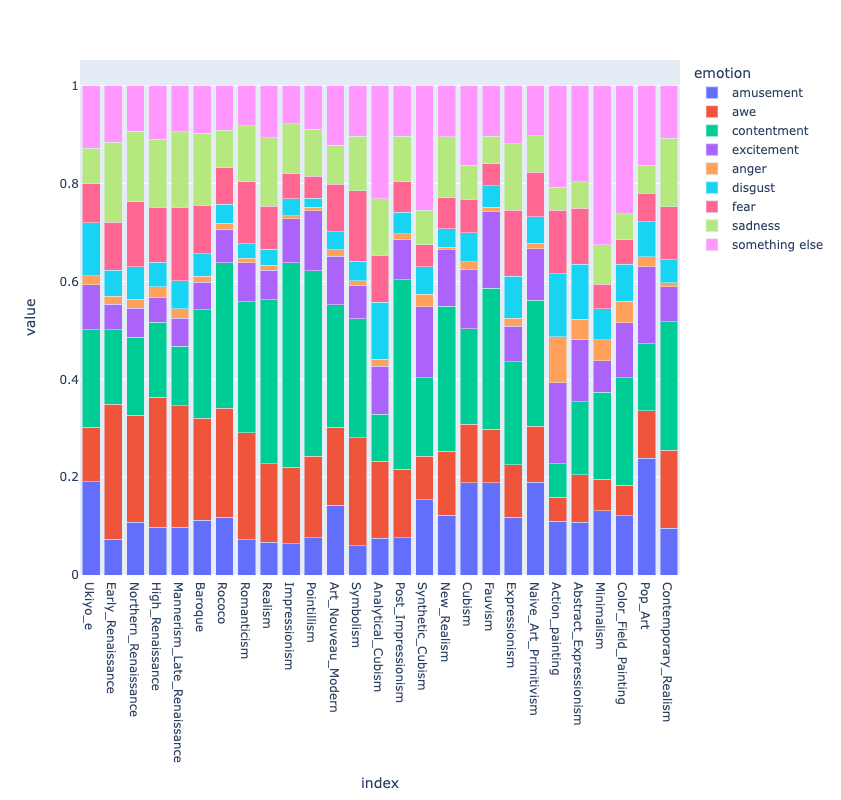

In [15]:

px.bar(avg_emotion_per_style[date_movements.sort_values().index].T[ARTEMIS_EMOTIONS],
       height = 800,
       barmode = "stack",)

## Main emotion per art movement

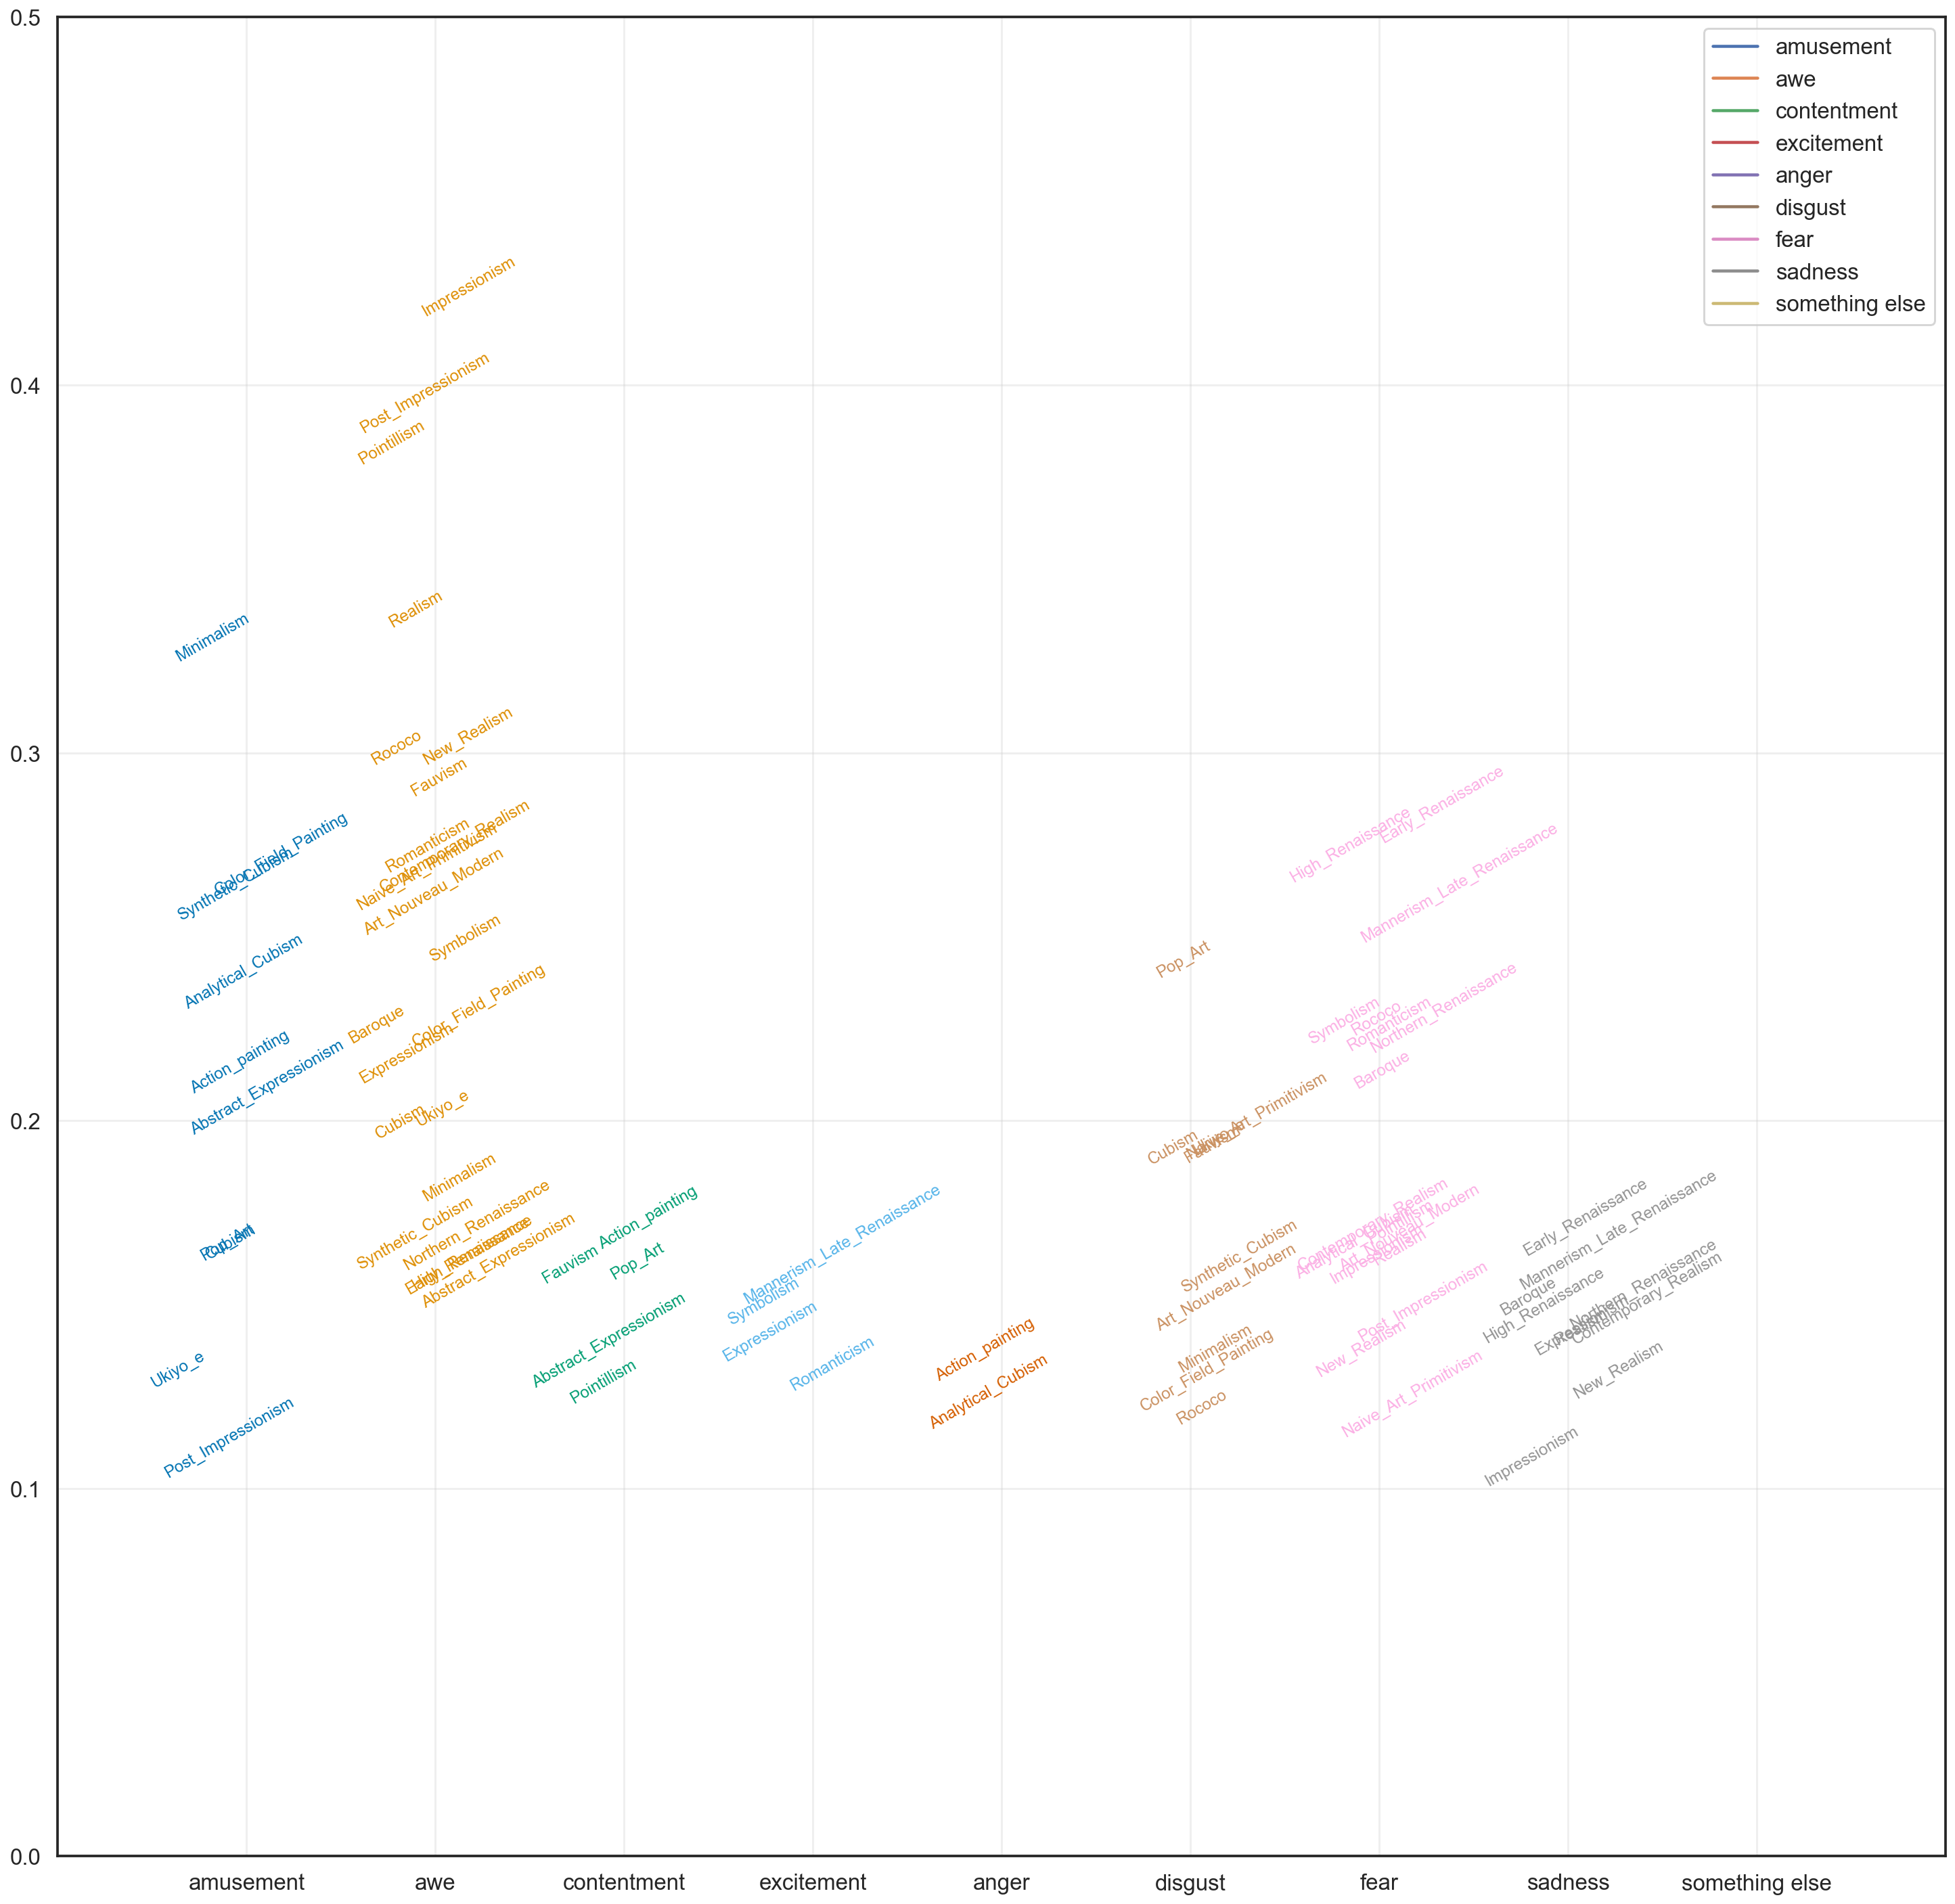

In [16]:
import torch
plt.figure(figsize = (25,25))
for scores, text in zip(avg_emotion_per_style.T.values, avg_emotion_per_style.T.index.to_list()) :
    vs, ids = torch.topk(torch.tensor(scores), 3)
    for v, i in zip(vs, ids):
        if v<0.1: continue
        x = i.tolist() 
        y = v.tolist()
        plt.plot(x , y, )
        plt.text(x * (1 + 0.01)+0.7 +(np.random.random(1)-0.5)/2 , y * (1)  , text, rotation =30, color=visual.emotion_colors()[x],  fontsize=12)

plt.ylim(0,0.5)
plt.xlim(0,10)
plt.grid(alpha = 0.3)
plt.xticks(range(1,10), ARTEMIS_EMOTIONS);
plt.legend(ARTEMIS_EMOTIONS)

#save_fig("../results/text_relation/art_style.pdf")

## Anger utterances

In [17]:
emotion = "anger"
art_style = "Minimalism"
tiny = dataset.head(10**5)
print("Sentence expressing {emotion} for the {art_style} art style :\n ")
print("\n".join(tiny[tiny.emotion_label == emotion2index[emotion]][tiny.art_style == "Minimalism"].utterance.head(10).to_list()))

Sentence expressing {emotion} for the {art_style} art style :
 
It makes me angry that someone thought this could be art.
a mattress covered in craft materials, i feel like this speaks to the wastefulness of people today, basically sleeping on trash to look good
This angers me because it is not art. It's some yellow paint with a little bit of 3d elements to it. I could make this in a kindergarten classroom.
The brash paint strokes invoke anger.
Who would buy a paintinglike this, and why?  it looks like a sheet of paper with a corner torn off.  I don't consider it art.
Broken window with cracks, everything falling apart
Why ruin such a beautiful scene with dark scratches.
This much red definitely evokes anger, that and/or the concept of a lot of blood.
It looks like a faint embossing of computer click art - and its annoying to look at.
How can this be called Art? laziness


<ipython-input-17-b2ab66fda546>:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



# Histogram analysis

In [18]:
from ast import literal_eval
hist = pd.read_csv(image_emotion_histogram_path)
hist.emotion_histogram = hist.emotion_histogram.map(literal_eval)
hist.head(2)

art_style                      painting  \
0  Abstract_Expressionism  aaron-siskind_acolman-1-1955   
1  Abstract_Expressionism    aaron-siskind_chicago-1951   

                               emotion_histogram  
0  [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0]  
1  [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0]

## Annotaors agreement

In [19]:

hist["n"] = hist.emotion_histogram.map(sum)
hist["prob"] = hist.emotion_histogram.map(np.array).map(lambda y: y/y.sum())
hist.head(2)

art_style                      painting  \
0  Abstract_Expressionism  aaron-siskind_acolman-1-1955   
1  Abstract_Expressionism    aaron-siskind_chicago-1951   

                               emotion_histogram    n  \
0  [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0]  5.0   
1  [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0]  6.0   

                                                prob  
0      [0.2, 0.0, 0.2, 0.0, 0.0, 0.0, 0.4, 0.0, 0.2]  
1  [0.0, 0.16666666666666666, 0.16666666666666666...

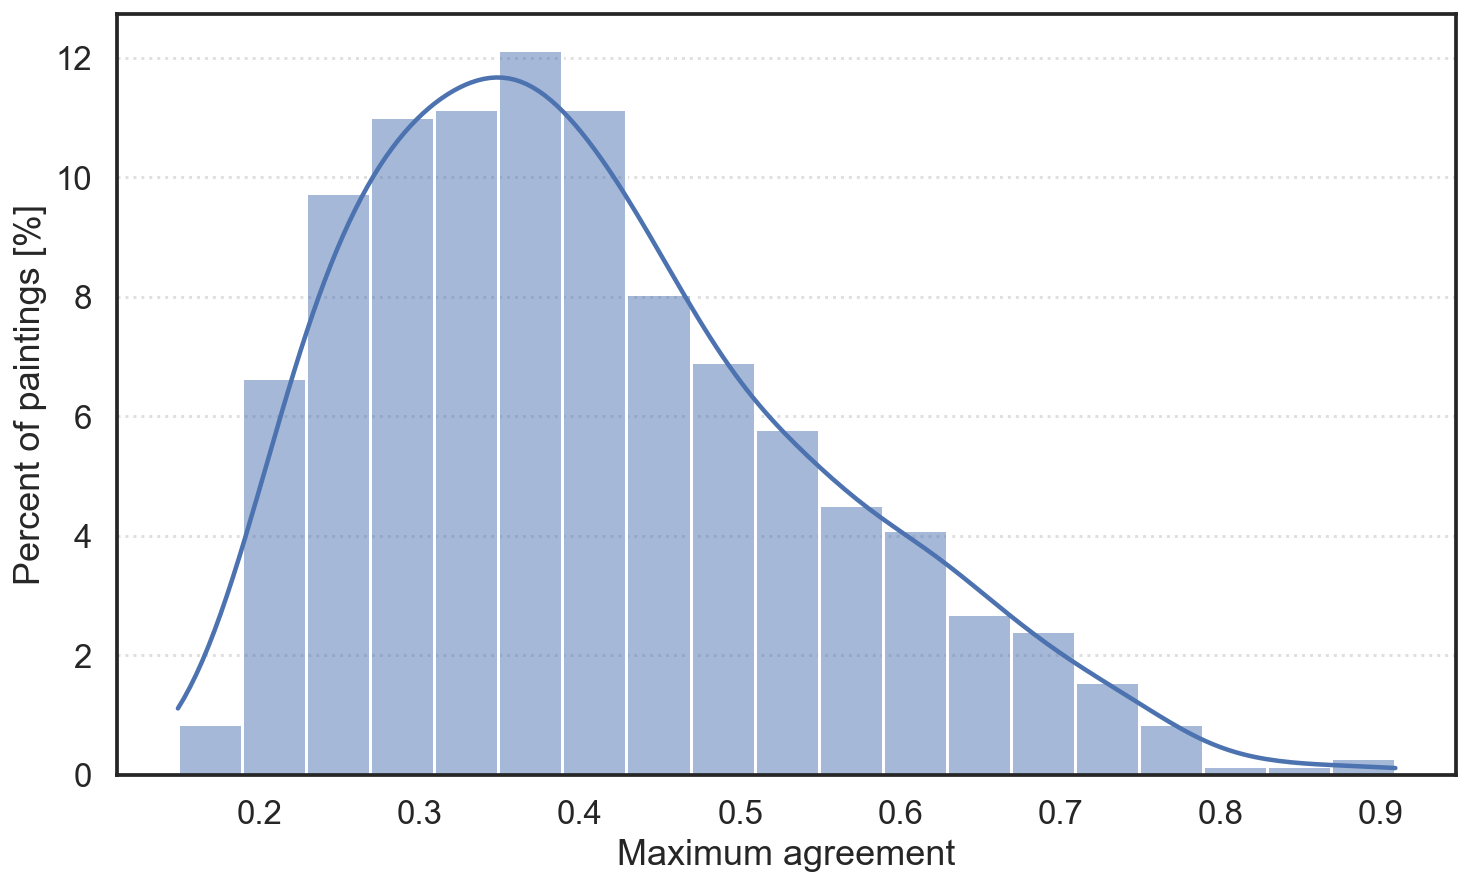

In [20]:
plt.figure(figsize=(12,7))
sns.histplot(hist[hist.n > 12].prob.map(np.max), stat = "percent", kde = True)
plt.xlabel("Maximum agreement")
plt.ylabel("Percent of paintings [%]")
plt.grid(axis = "y", ls = ":", alpha = 0.6);
#plt.savefig("../results/figures/user_agreement_distribution.pdf", bbox_inches = "tight")

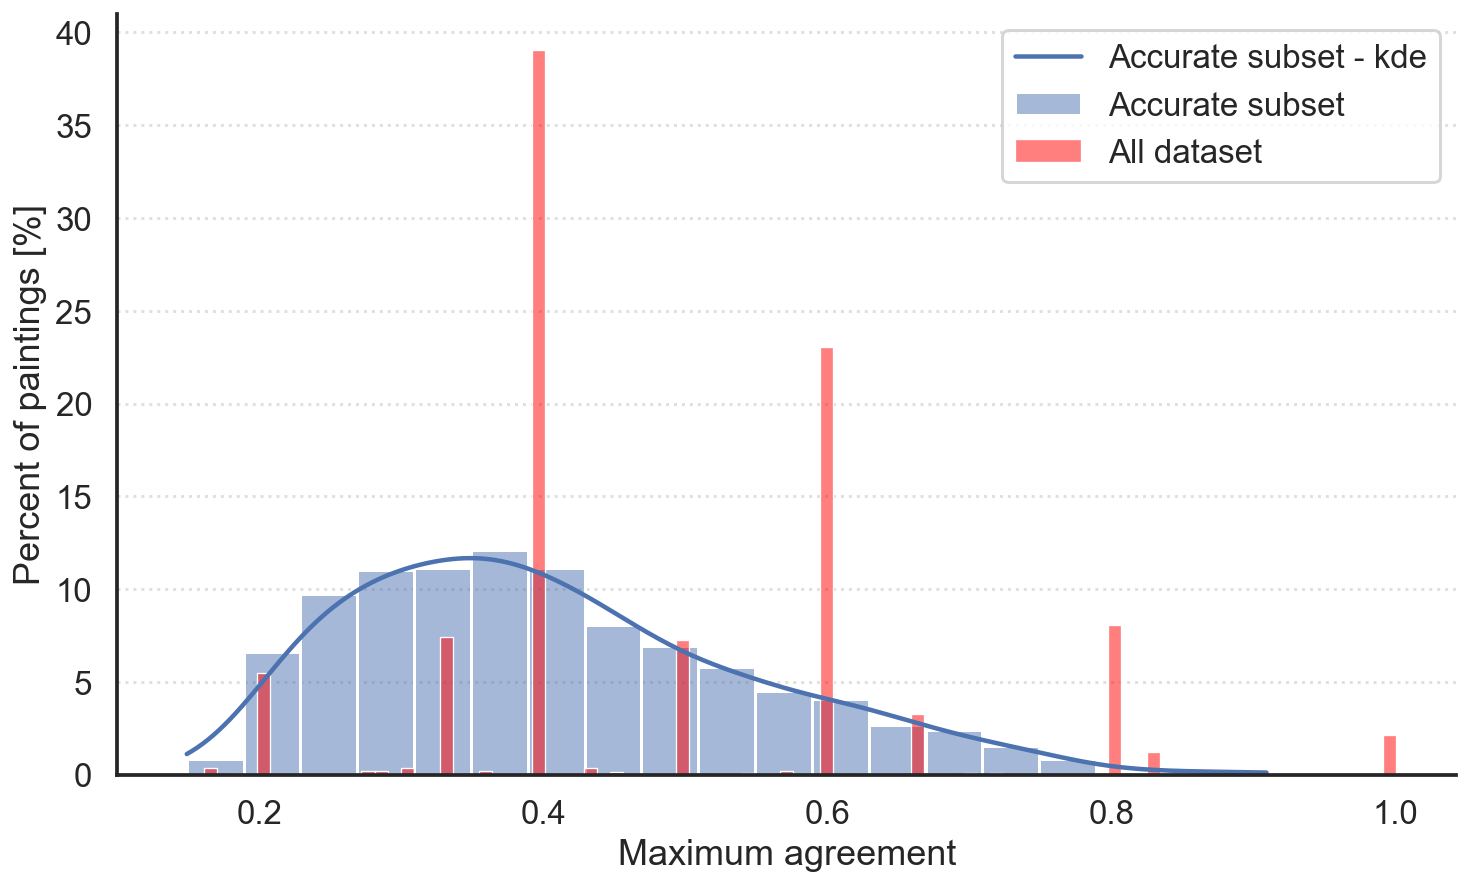

In [21]:
plt.figure(figsize=(12,7))
sns.histplot(hist[hist.n > 12].prob.map(np.max), stat = "percent", kde = True)
sns.histplot(hist[hist.n > 4].prob.map(np.max), stat = "percent", color ="red", alpha = 0.5)
plt.legend(["Accurate subset - kde","Accurate subset", "All dataset"])
plt.xlabel("Maximum agreement")
plt.ylabel("Percent of paintings [%]")
plt.grid(axis = "y", ls = ":", alpha = 0.6)
sns.despine()

## Emotion agreement

In [22]:
emotion_histogram = hist.emotion_histogram

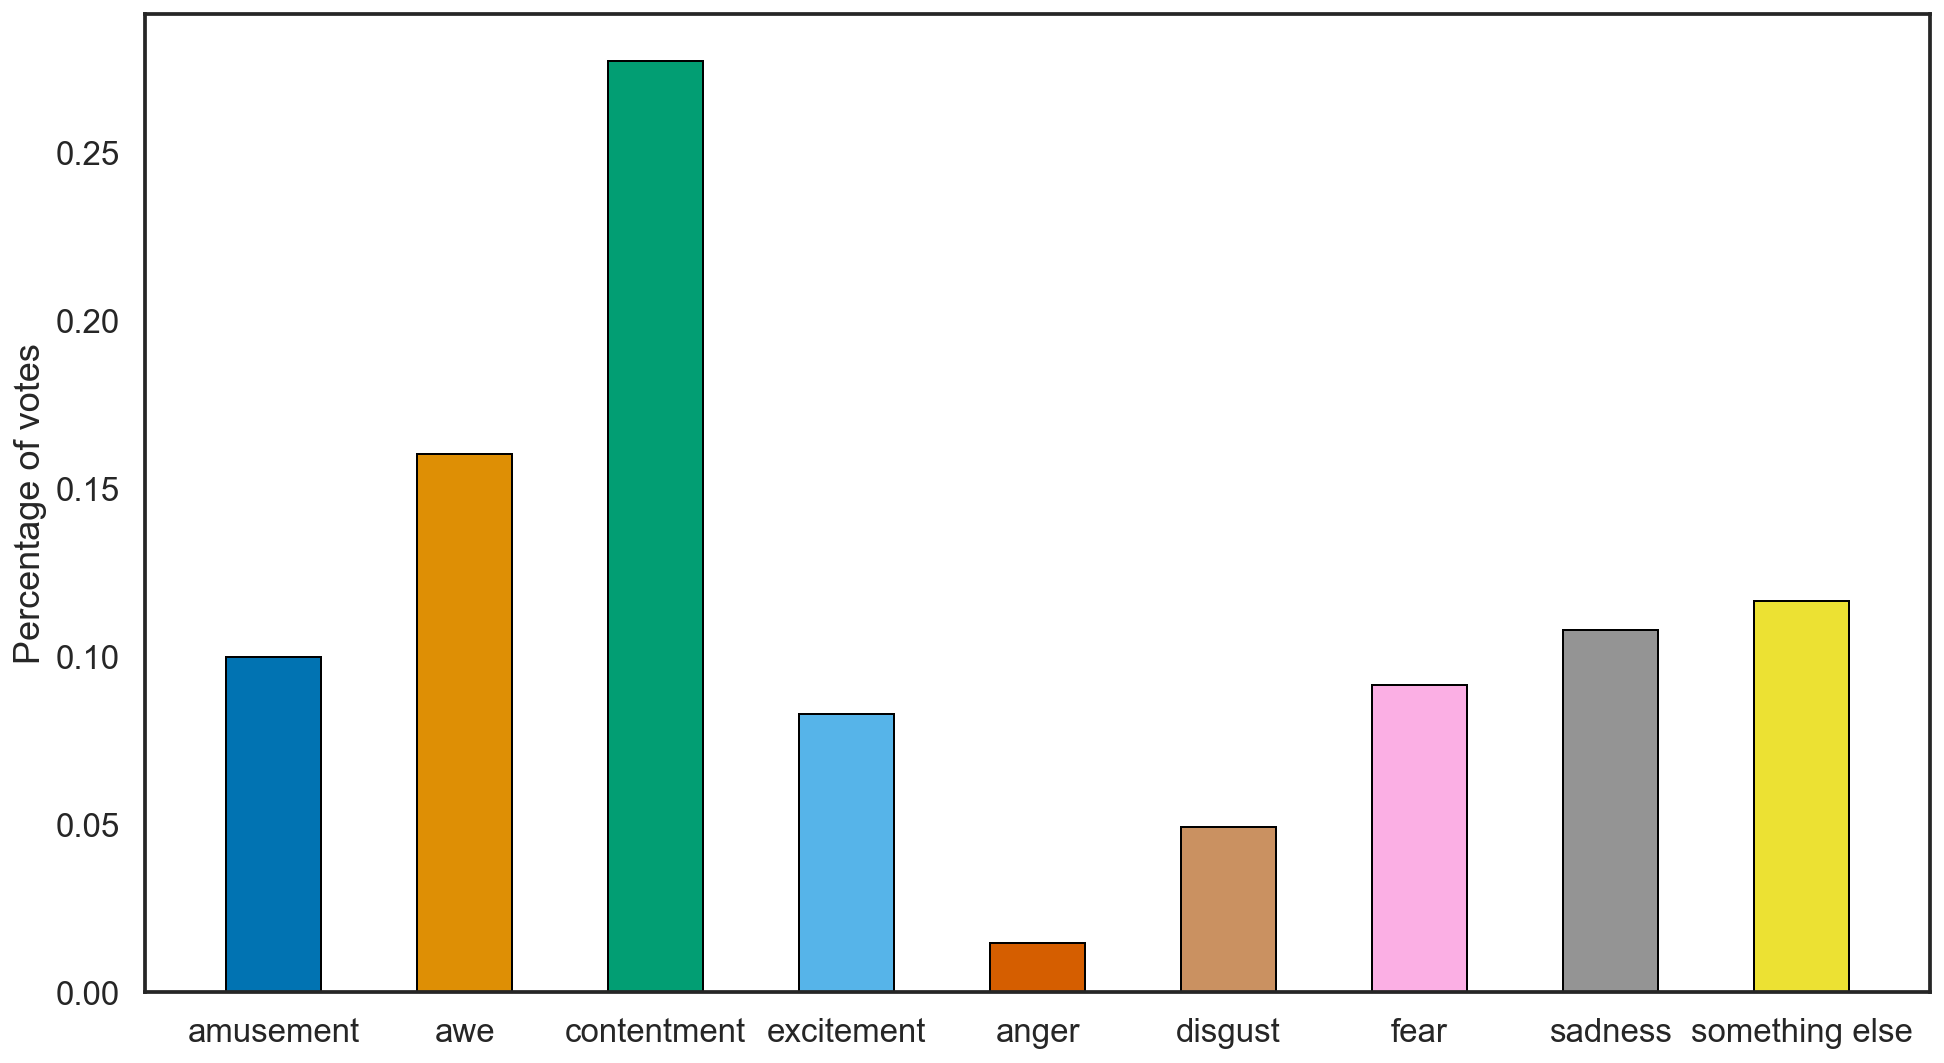

In [23]:
cols = visual.emotion_colors()
visual.standardized_fig()
count_per_emotion = emotion_histogram.map(np.array).sum()
count_per_emotion_normalized = count_per_emotion/count_per_emotion.sum()
plt.bar(x = ARTEMIS_EMOTIONS,height =count_per_emotion_normalized , color = cols, edgecolor = "black", width=0.5, linewidth = 1);
plt.ylabel("Percentage of votes")
plt.grid(axis = "y", ls = ":", alpha = 0.8)

In [24]:
def agreement(hist, index_emotion, bool_it = False):
    n_voters = hist[index_emotion]
    if not bool(n_voters):
        return None
    agreement = (n_voters-1)/(np.sum(hist)-1)
    if bool_it:
        agreement = bool(agreement)
    return agreement, n_voters

def get_agreement(emotion_histogram, emotion, bool_it = False):
    emotion_agreement = emotion_histogram.map(lambda y: agreement(y, emotion2index[emotion], bool_it))
    voters = emotion_agreement[~emotion_agreement.isna()]
    weighted_agreement = voters.map(lambda y : y[0]*y[1]).sum()
    total_voters = voters.map(lambda y : y[1]).sum()
    avg_agreement = weighted_agreement / total_voters
    return emotion,np.round(avg_agreement,2)

In [25]:
expected = []
for i in count_per_emotion_normalized.round(2) :
    expected.append(1-(1-i)**4)


In [26]:
agreements = []
for emotion in ARTEMIS_EMOTIONS:
    agreements.append(get_agreement(emotion_histogram, emotion, True))

In [27]:
df = pd.DataFrame(agreements).set_index(0)
df["Expected"] = expected
df.columns = ["Actual", "Expected"]
df

Actual  Expected
0                               
amusement         0.58  0.343900
awe               0.64  0.502129
contentment       0.83  0.731261
excitement        0.48  0.283607
anger             0.21  0.039404
disgust           0.41  0.185494
fear              0.63  0.314250
sadness           0.62  0.372578
something else    0.52  0.400305

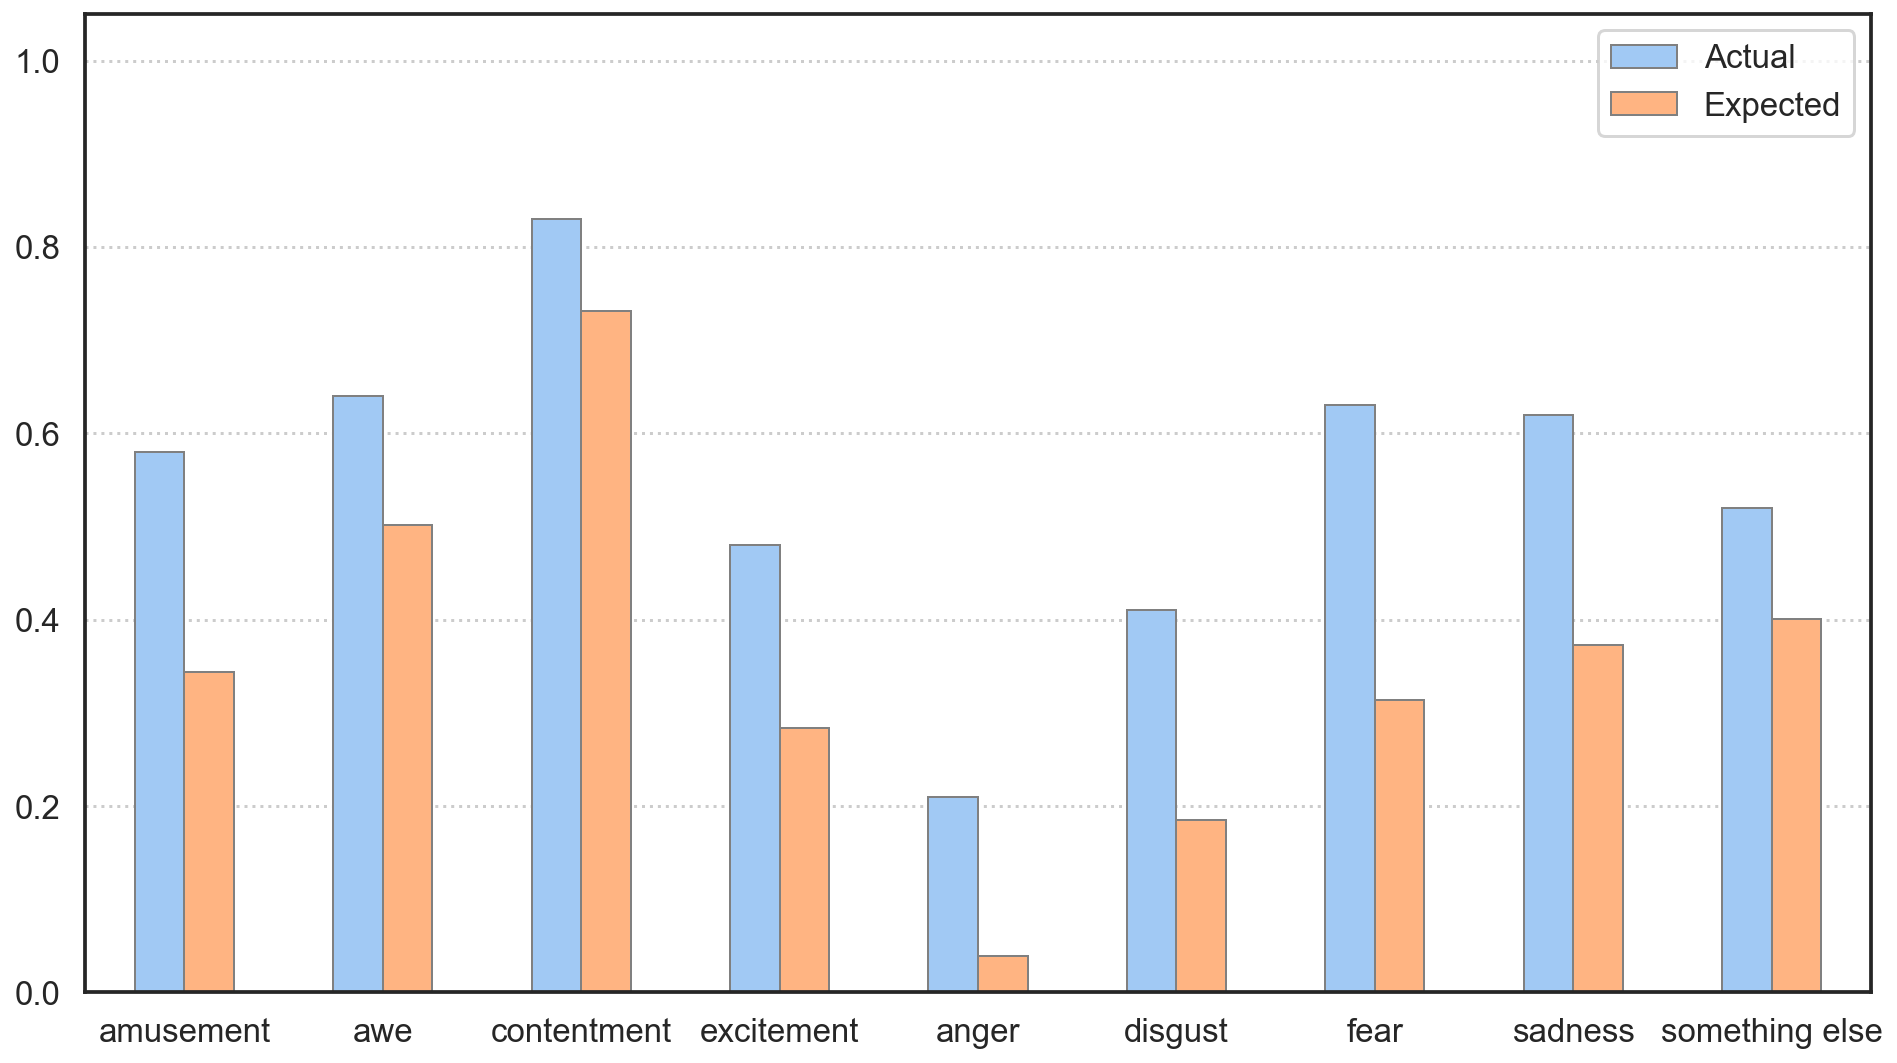

In [28]:
df.plot.bar(figsize =(16,9), color=sns.color_palette("pastel"), edgecolor = "grey", linewidth=1 )
plt.xticks(rotation=0);
plt.xlabel("")
plt.grid(axis = "y", ls=":")
plt.ylim(0, 1.05);
#save_fig("../figures/actual_expected.pdf")

### $\chi^{2}$ test of independance

The $\chi^2$ test is a meadure of indepence bewteen two probabilities. Here we compare the probability of someone choosing an emotion knowing that someone voted for it versus its expected value taken from the distribution of votes

In [29]:
freq = df.apply(lambda y : y*hist.emotion_histogram.map(np.array).sum())

In [30]:

pd.DataFrame(((freq["Actual"]-freq["Expected"])**2/freq["Expected"]).sort_values(), columns = ["$\chi^2$"])

$\chi^2$
0                           
contentment      1681.640172
something else   1895.520054
awe              2760.714362
anger            4904.171148
excitement       5118.447868
disgust          6089.600833
amusement        7348.572750
sadness          8061.163551
fear            13190.551982

## Angry picture in test set

In [31]:
from io import BytesIO
from PIL import Image
import requests



In [32]:
emotion2index = dict(zip(ARTEMIS_EMOTIONS, range(9)))
anger = emotion2index["anger"]

In [33]:
painting_split = dataset.set_index("painting")["split"]

In [34]:
split = "test"
subset = painting_split[painting_split == split]
subset = subset.index.drop_duplicates()

In [35]:
hist["dominant"] = hist.emotion_histogram.map(np.argmax)
hist["dominant_count"] = hist.emotion_histogram.map(np.max)


In [36]:
hist_subset = hist.set_index("painting").loc[subset.tolist()].reset_index()
hist_subset.head()

painting             art_style  \
0  paul-gauguin_mette-gauguin-in-an-evening-dress...         Impressionism   
1                      willard-metcalf_havana-harbor         Impressionism   
2      robert-campin_werl-altarpiece-st-barbara-1438  Northern_Renaissance   
3            john-singer-sargent_the-bridge-of-sighs         Impressionism   
4  john-singer-sargent_palazzo-corner-della-ca-gr...         Impressionism   

                               emotion_histogram    n  \
0  [2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0]  7.0   
1  [0.0, 4.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]  7.0   
2  [1.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  7.0   
3  [0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0]  6.0   
4  [1.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  6.0   

                                                prob  dominant  dominant_count  
0  [0.2857142857142857, 0.14285714285714285, 0.14...         0             2.0  
1  [0.0, 0.5714285714285714, 0.2857142857142857, ...         1             4.0  
2  [0.14285714285714285, 0.0, 0.8571428571428571,...         2             6.0  
3  [0.0, 0.3333333333333333, 0.3333333333333333, ...         1             2.0  
4  [0.16666666666666666, 0.6666666666666666, 0.16...         1             4.0

In [37]:
emotion = "awe"
wikiart_path = "../../code/artemis/data_sets/wikiart/"
show_n = 10

top_emotion_paintings = hist_subset[hist_subset.dominant == emotion2index[emotion]].dominant_count.nlargest(show_n).index
for painting in top_emotion_paintings :
    p_path = osp.join(wikiart_path, hist_subset.loc[painting]["art_style"], f"""{hist_subset.loc[painting]["painting"]}.jpg""")
    img = Image.open(p_path)
    w, h = img.size
    ratio_size = (w+h) // 400
    if ratio_size > 2 :
        w = w//(ratio_size-1)
        h = h//(ratio_size-1)
    
    img.resize((w,h), Image.BILINEAR).show()


# Entropy

In [38]:
unique_n_users = pd.DataFrame(hist.n.value_counts()).sort_index()

In [39]:
hist["entropy"] = hist.emotion_histogram.map(entropy)
hist.head(2)

art_style                      painting  \
0  Abstract_Expressionism  aaron-siskind_acolman-1-1955   
1  Abstract_Expressionism    aaron-siskind_chicago-1951   

                               emotion_histogram    n  \
0  [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0]  5.0   
1  [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0]  6.0   

                                                prob  dominant  \
0      [0.2, 0.0, 0.2, 0.0, 0.0, 0.0, 0.4, 0.0, 0.2]         6   
1  [0.0, 0.16666666666666666, 0.16666666666666666...         6   

   dominant_count   entropy  
0             2.0  1.332179  
1             2.0  1.560710

In [40]:
f = {}
for users in unique_n_users[unique_n_users.n > 12].index :
    f[users] = hist[hist.n == users].entropy.describe()


In [41]:
f = pd.DataFrame( index = f.keys(), data = f.values())

In [42]:
f = f.sort_index()
f

count      mean       std       min       25%       50%       75%  \
5.0   61600.0  1.048056  0.343639  0.000000  0.950271  1.054920  1.332179   
6.0   15644.0  1.117846  0.345443  0.000000  0.867563  1.242453  1.329661   
7.0     662.0  1.151153  0.346486  0.000000  0.955700  1.277034  1.351784   
8.0      31.0  1.182583  0.335406  0.562335  0.900256  1.255482  1.494175   
10.0    824.0  1.372843  0.309839  0.000000  1.193550  1.418484  1.609438   
11.0    480.0  1.442084  0.281611  0.000000  1.292972  1.468140  1.641735   
12.0     80.0  1.478221  0.302518  0.562335  1.273714  1.545423  1.704551   
44.0     59.0  1.591005  0.314441  0.399156  1.431222  1.614549  1.814934   
45.0    128.0  1.622919  0.293304  0.899608  1.447166  1.684256  1.841022   
46.0    130.0  1.576664  0.278035  0.801816  1.422917  1.610858  1.772605   
47.0     55.0  1.588921  0.307490  0.622064  1.409659  1.619696  1.814133   
48.0     76.0  1.538151  0.267528  0.456334  1.381065  1.519096  1.754164   
49.0     69.0  1.596666  0.336705  0.767323  1.378085  1.725135  1.841185   
50.0     66.0  1.578369  0.262512  0.896846  1.428566  1.614813  1.788359   
51.0     51.0  1.505591  0.285160  0.972104  1.356432  1.502262  1.738611   
52.0     21.0  1.598489  0.242580  1.177197  1.373876  1.712417  1.789574   
53.0     16.0  1.529006  0.351752  0.776787  1.315962  1.602189  1.839466   

           max  
5.0   1.609438  
6.0   1.791759  
7.0   1.945910  
8.0   1.732868  
10.0  2.163956  
11.0  2.019815  
12.0  1.979205  
44.0  2.118043  
45.0  2.107086  
46.0  2.059260  
47.0  2.106386  
48.0  1.970785  
49.0  2.089636  
50.0  1.983779  
51.0  2.028357  
52.0  1.897913  
53.0  1.985062

Text(0.5, 0, 'Number of voters')

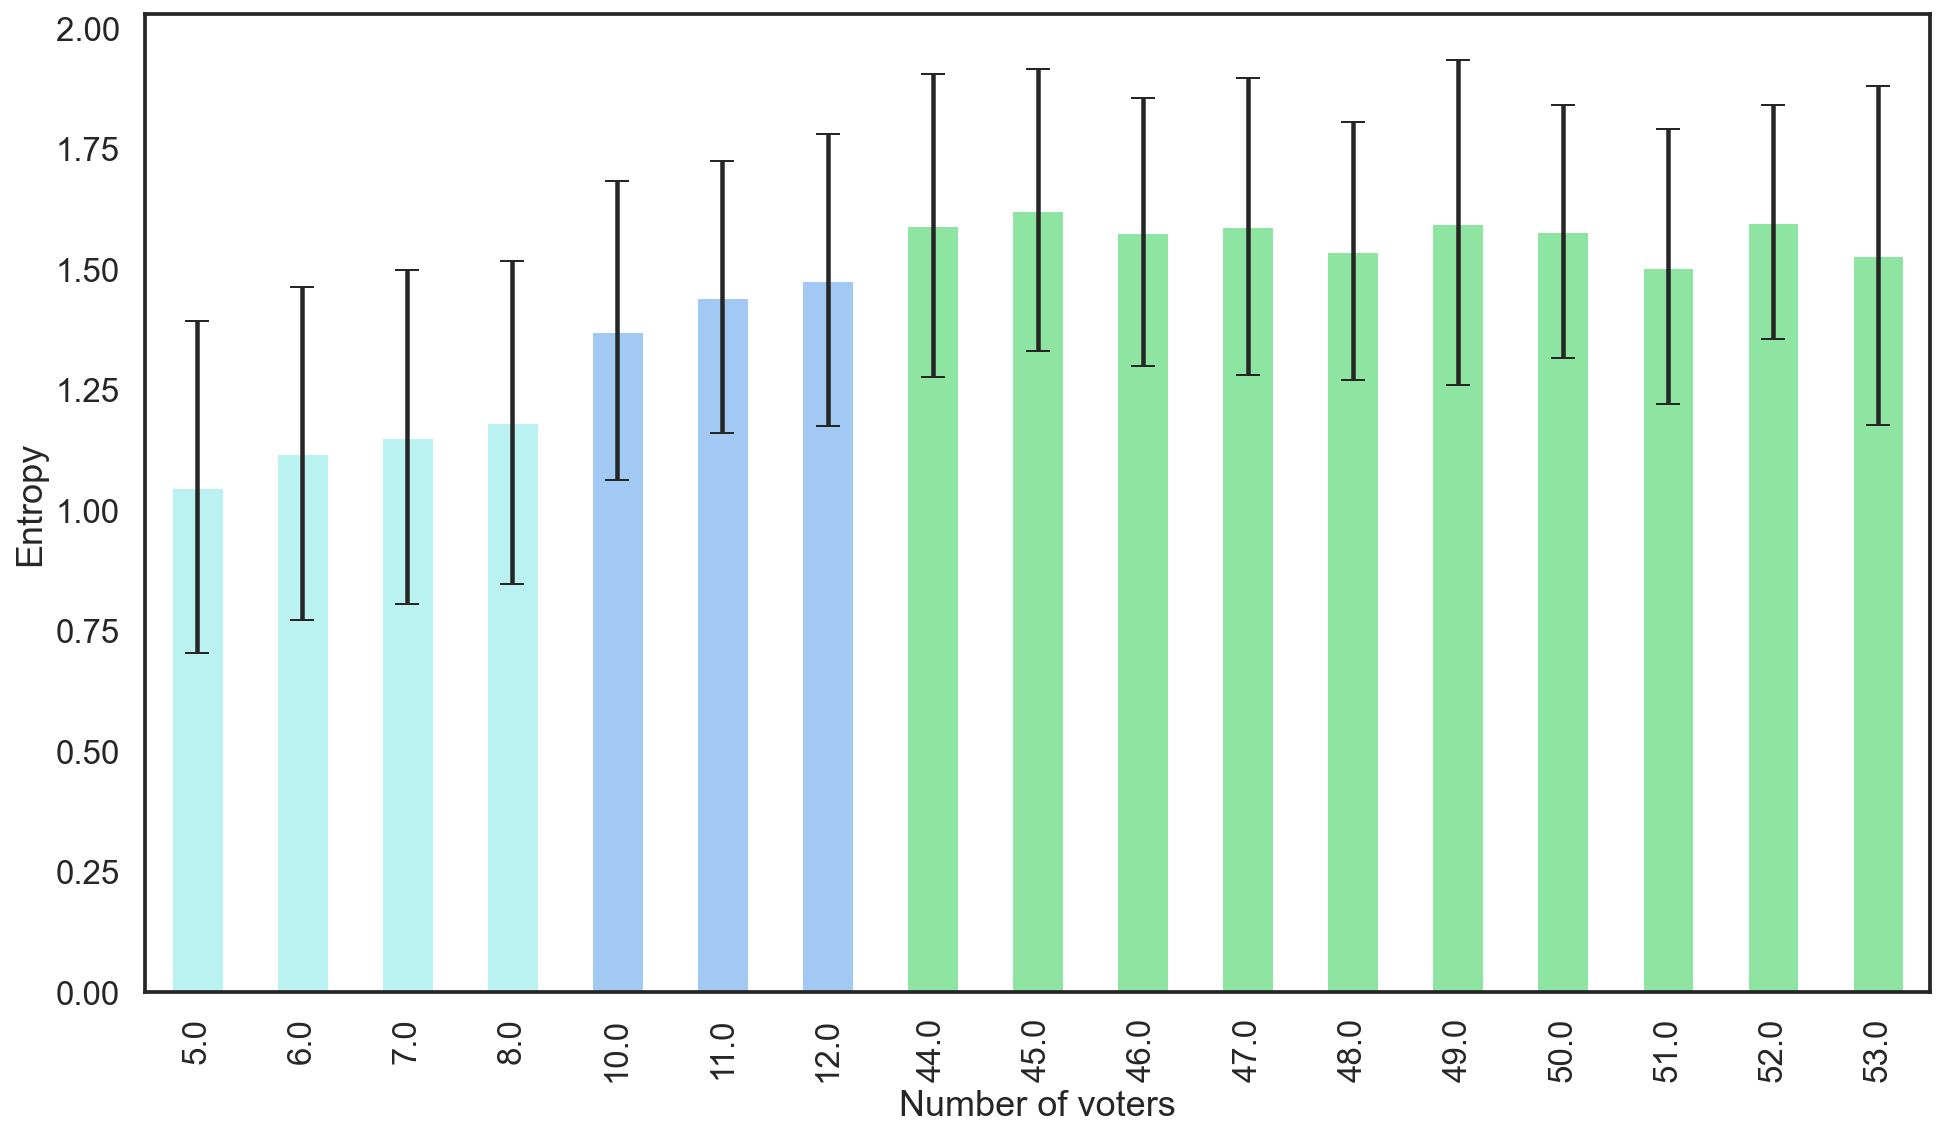

In [43]:
b = sns.palettes.color_palette("pastel6")
f["mean"].plot(kind = "bar", figsize = (16,9),
               yerr = f["std"],
               capsize = 6,
               color= [b[5]]*4 + [b[0]]*3 + [b[1]]*10);
plt.ylabel("Entropy")
plt.xlabel("Number of voters")
#save_fig("figures/bar_entropy.svg")

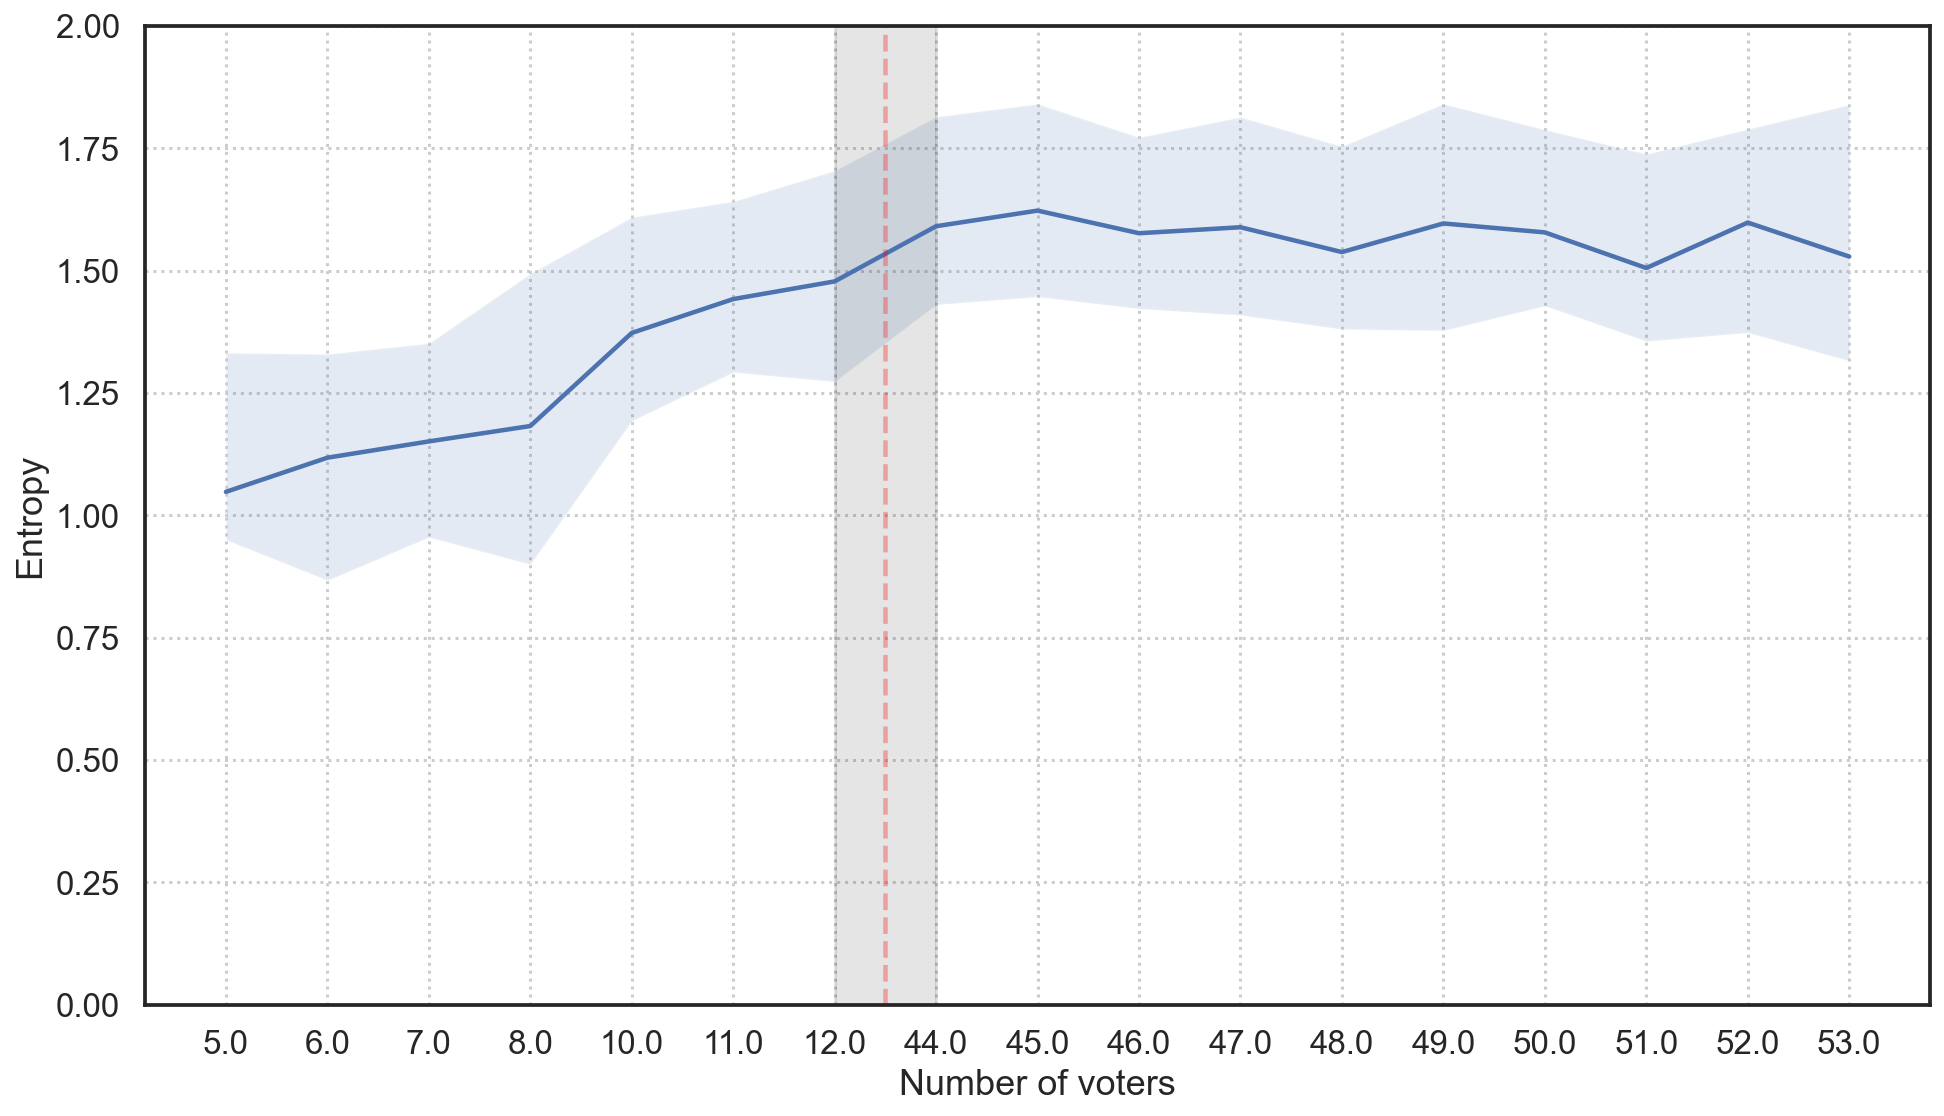

In [44]:
plt.figure(figsize=(16,9))
f.index = f.index.astype(str)
plt.plot(f["mean"])
fig = plt.fill_between(x=f.index, y1=f["25%"], y2=f["75%"], alpha=0.15, );
plt.ylim((0,2))
plt.ylabel("Entropy")
plt.xlabel("Number of voters")
plt.axvline(x=6.5, color='red', linestyle='--', alpha = 0.3)
plt.fill_betweenx(y=(0,2), x1=6, x2=7, alpha=0.1, color="black", interpolate=True )
plt.grid(ls=":")
#save_fig("figures/line_entropy")

## Expected annotation error

In [45]:
more_than15 = hist[hist.n>15]

In [46]:
AGREEMENT = 0.5
probs_high_agreement = more_than15.emotion_histogram.map(np.array).map(lambda y : y/y.sum())
probs_high_agreement = probs_high_agreement[probs_high_agreement.map(lambda y : y.max() > AGREEMENT)]

In [47]:
a=np.array(hist[hist.n>15].emotion_histogram.map(np.array).to_list())

In [48]:
def experiment(real_hist, n_samples):
    probs = np.array(real_hist)
    probs /= probs.sum()
    predictions = np.random.choice(np.arange(9), size=n_samples, p=probs)
    preds = torch.nn.functional.one_hot(torch.tensor(predictions), 9).sum(0).numpy()
    return preds/preds.sum()

In [49]:
n_exp = 100
n_voters = 5
def annotator_confidence(probs, n_voters, n_exp=100):
    probs["results"] = probs.prob.map(lambda y : [experiment(y, n_voters) for _ in range(n_exp)])
    probs["true_max"] = probs.prob.map(lambda y : max(y)>0.5)
    probs["portion_max"] = probs.results.map(lambda y : (np.array(y).max(1) > 0.5).sum())
    prop_true_pos = probs[probs.true_max].portion_max.mean()*100/n_exp
    prop_false_pos = probs[~probs.true_max].portion_max.mean()*100/n_exp
    prop_true_neg = 100 - prop_false_pos
    prop_false_neg = 100 - prop_true_pos
    conf = pd.DataFrame([[prop_true_pos,prop_false_pos],[prop_false_neg, prop_true_neg]])
    conf.index = conf.columns = ["Dominant emotion", "Not dominant emotion"]
    return conf, probs

In [50]:
from tqdm import tqdm
res = []
for x in tqdm(range(2, 45)):
    res.append([x, annotator_confidence(hist[hist.n>15], x)])


  0%|          | 0/43 [00:00<?, ?it/s]<ipython-input-49-c367e42fffe9>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-49-c367e42fffe9>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-49-c367e42fffe9>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [51]:
TP = pd.DataFrame([[a[0], a[1][0].to_numpy()[0,0]] for a in res]).set_index(0)
FN = pd.DataFrame([[a[0], a[1][0].to_numpy()[0,1]] for a in res]).set_index(0)
FP = pd.DataFrame([[a[0], a[1][0].to_numpy()[1,0]] for a in res]).set_index(0)
TN = pd.DataFrame([[a[0], a[1][0].to_numpy()[1,1]] for a in res]).set_index(0)

In [52]:
metrics = pd.concat([TP,FN, FP, TN], axis = 1)
metrics.columns = ["TP", "FN", "FP", "TN"]
metrics["TP-TN average"] = (1/2) * (metrics["TP"]+metrics["TN"])
metrics["FP-FN average"] = (1/2) * (metrics["FP"]+metrics["FN"])

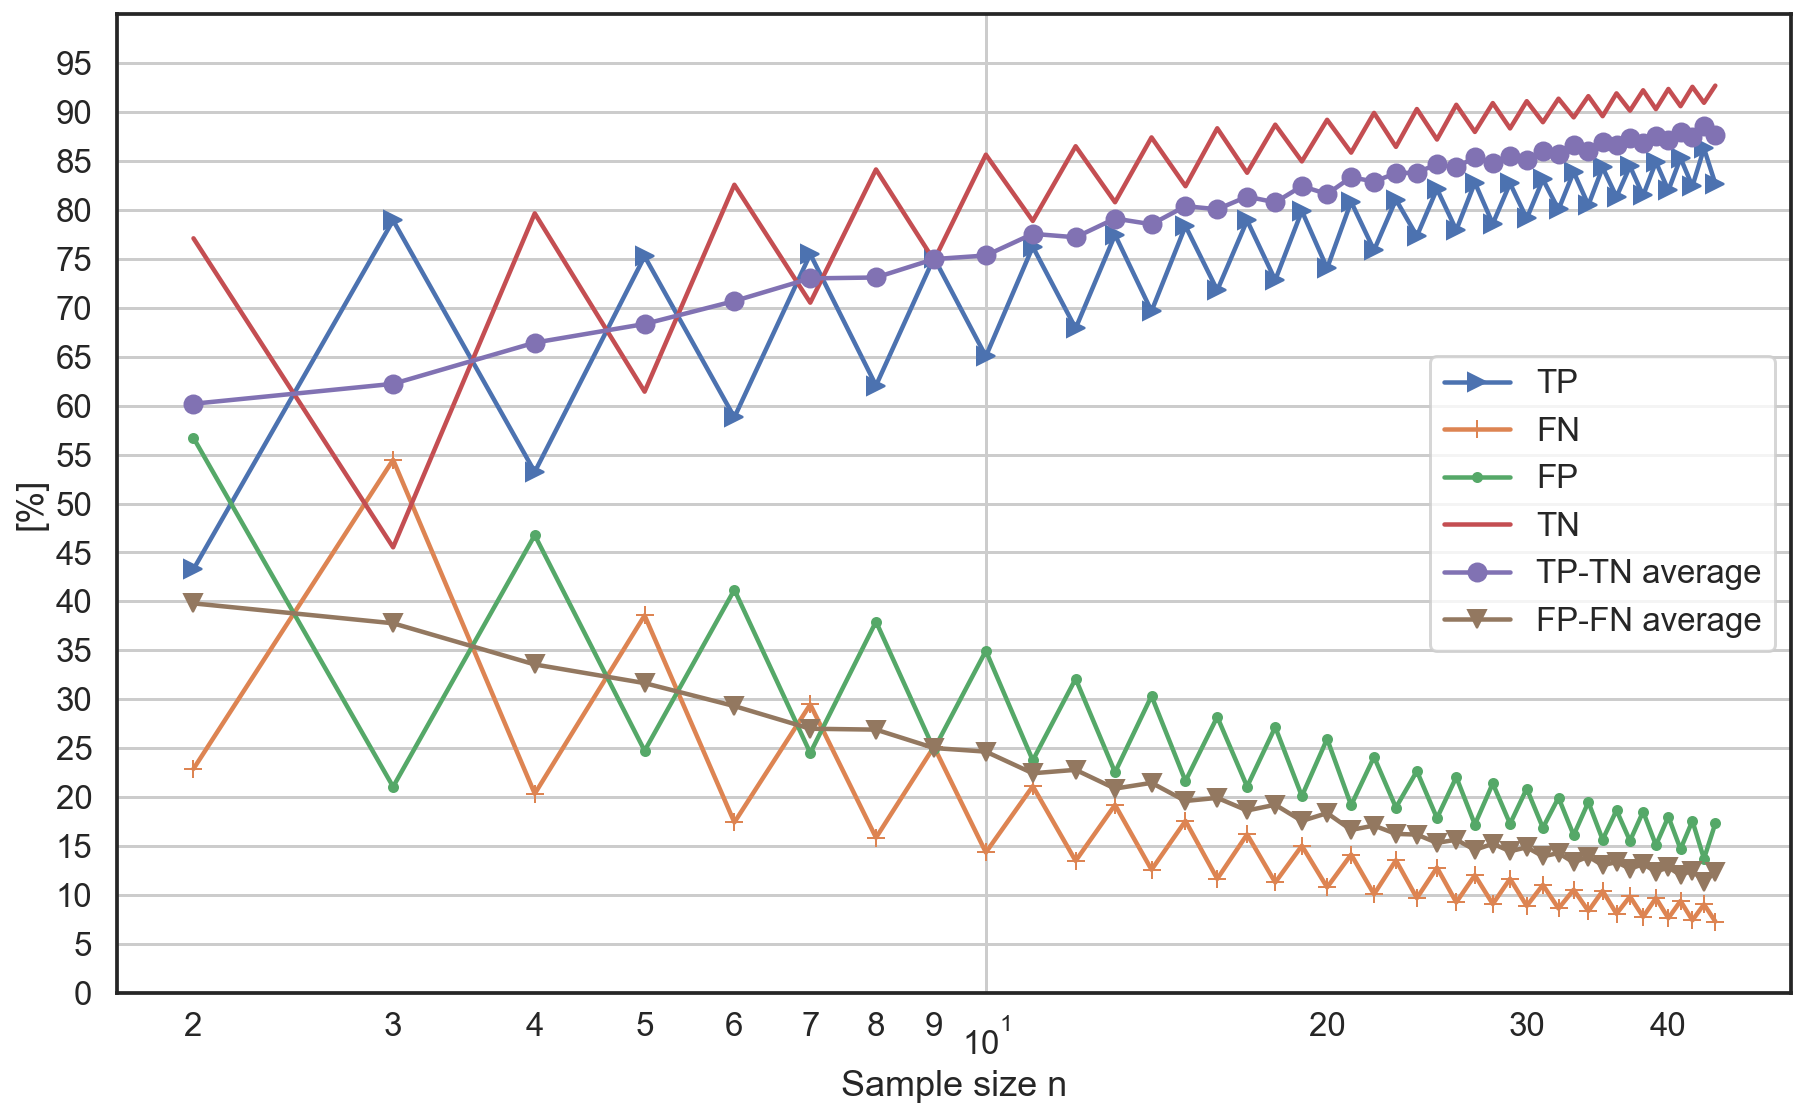

In [53]:
#metrics.columns = ["Numer of users"]
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
markers = ['>', '+', '.', ',', 'o', 'v', 'x', 'X', 'D', '|']


ax = metrics.plot.line(figsize=(15,9), );

#plt.fill_betweenx(y=(0,2),x1=6, x2=7, alpha = 0.1, color="black", interpolate=True )
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

plt.ylim(0,100)
plt.ylabel("[%]")
plt.xscale("log")


ax.set_xticks(ticks = list(range(2,11,1)) + list(range(10, 44, 10)), minor = True)


ax.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))

plt.grid( )


plt.yticks(ticks = range(0,100, 5))


plt.xlabel("Sample size n")
ax.legend(ax.get_lines(), metrics.columns, loc='best')
#save_fig("figures/precision_annotators.pdf")

In [54]:
art_entropy = []
for art_style in hist.art_style.unique():
    description = hist[hist.art_style == art_style].entropy.describe()
    art_entropy.append([art_style, description])

In [55]:
art_df = pd.DataFrame(pd.concat(np.array(art_entropy)[:,1], axis = 1))
art_df.columns = np.array(art_entropy)[:,0]

<ipython-input-55-7783c688c027>:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

<ipython-input-55-7783c688c027>:2: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



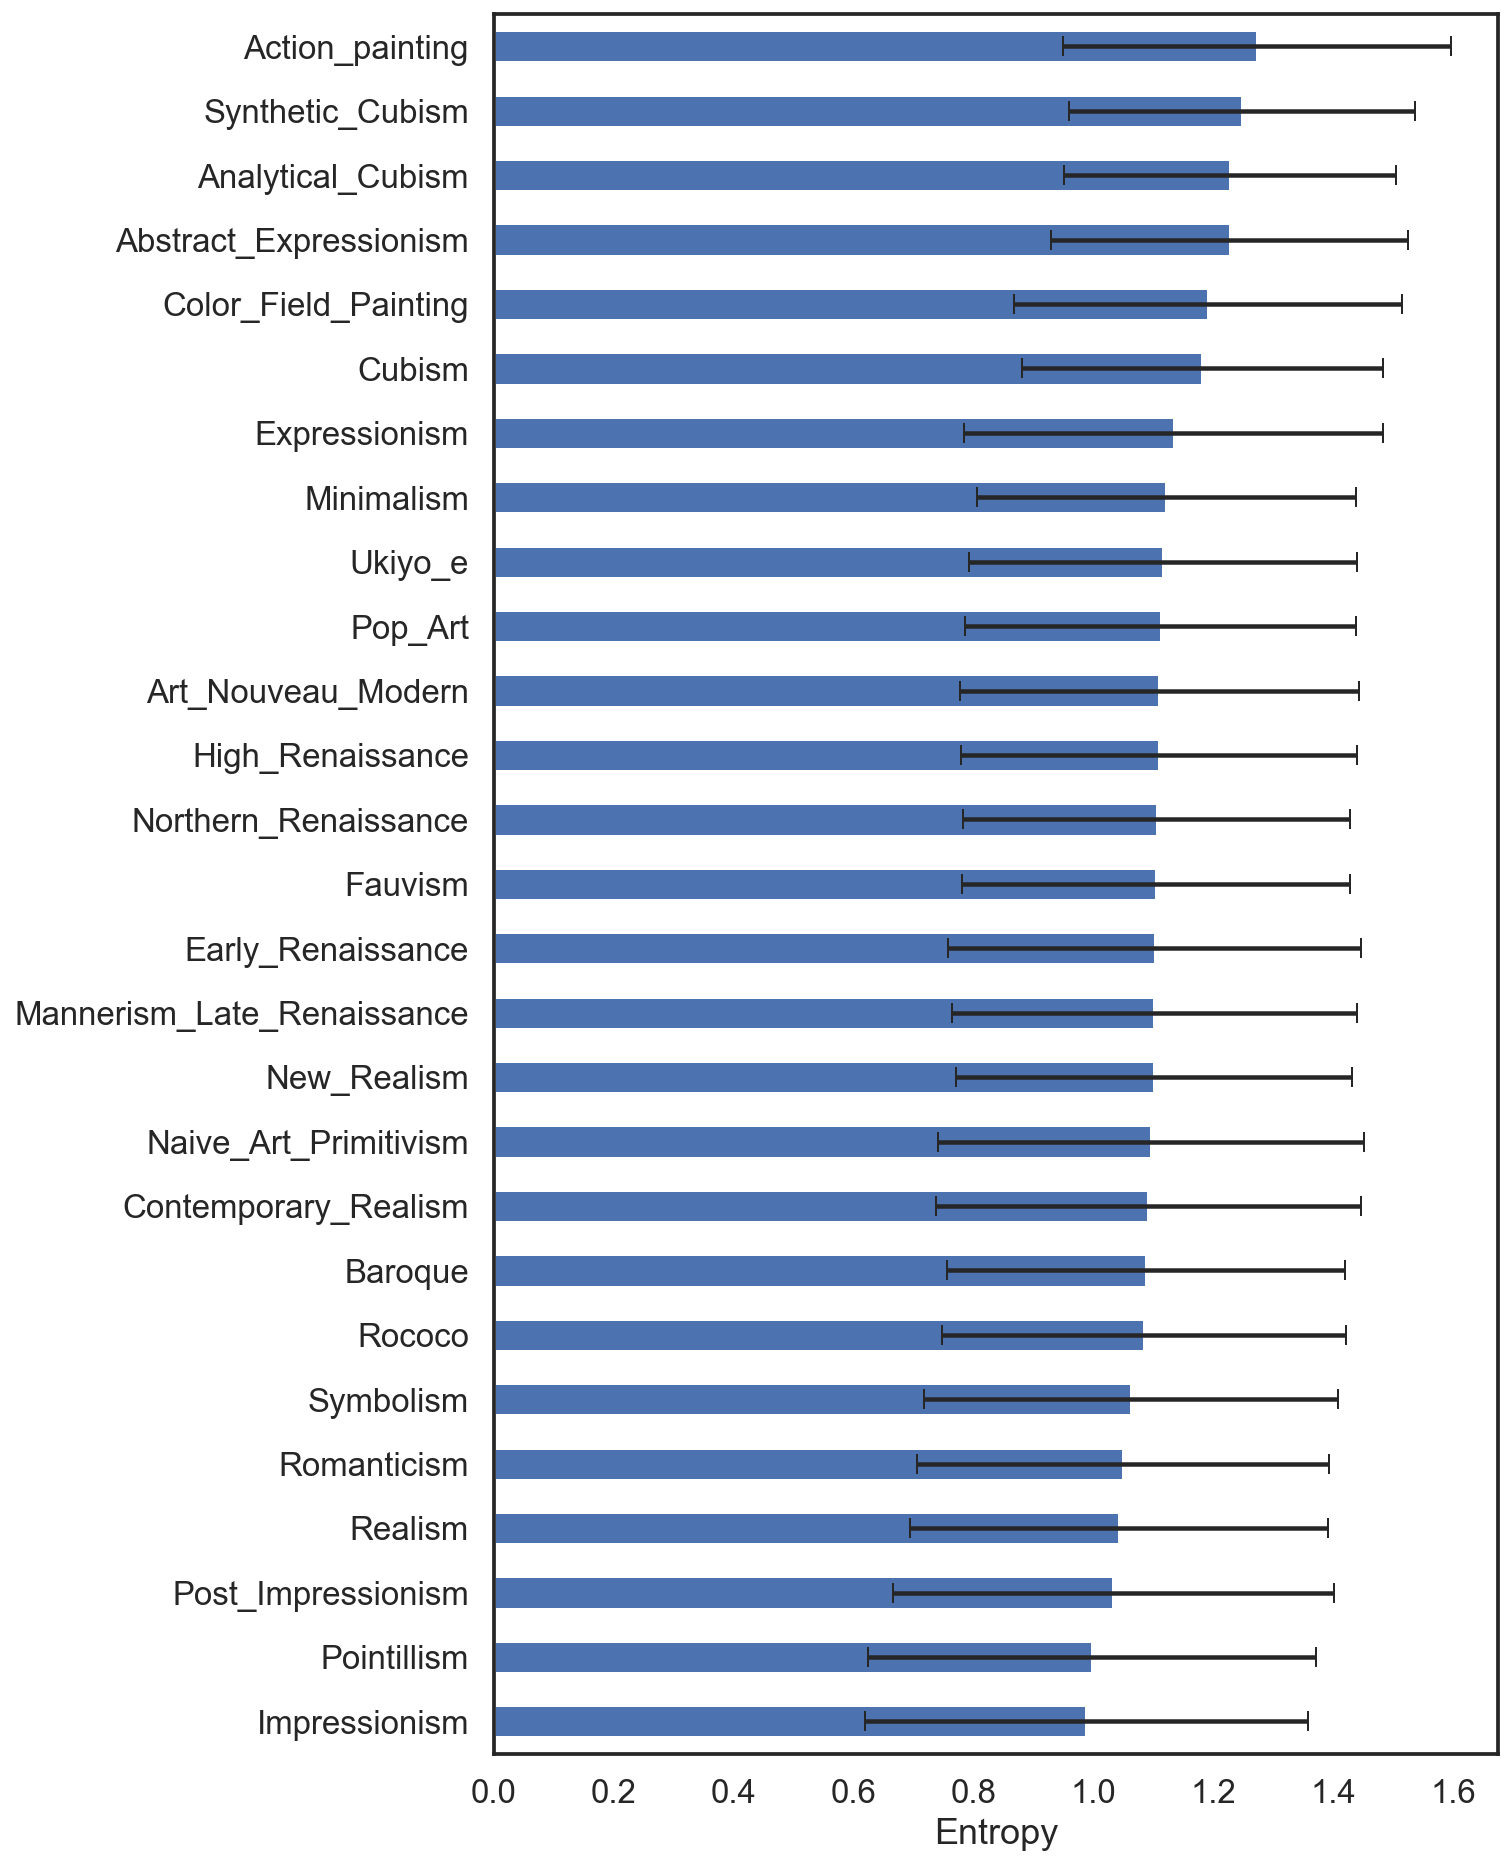

In [56]:
art_df.T.sort_values(by = "mean")["mean"].plot(kind = "barh", figsize = (9,16), xerr=art_df.T["std"], capsize=5);
plt.xlabel("Entropy");
#save_fig("figures/entropy_per_style.pdf")